# Seawater Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import statsmodels.api as sm

## Data

In [2]:
Hodell1991 = pd.read_csv('Data/Hodell1991a_supplement.csv')
Hodell1994 = pd.read_csv('Data/Hodell1994a_supplement.csv')
Oslick1994 = pd.read_csv('Data/Oslick1994a_supplement.csv')
Peucker1995 = pd.read_csv('Data/Peucker-Ehrenbrink1995a_supplement.csv')
Ravizza1993 = pd.read_csv('Data/Ravizza1993a_supplement.csv')
Reusch1998 = pd.read_csv('Data/Reusch1998a_supplement.csv')
LOWESS = pd.read_csv('Data/LOWESS.csv')

In [3]:
# ratio to convert from 187Os/186Os to 187Os/188Os
Os_conversion_ratio = 0.12035

Hodell1991_age = Hodell1991['Age [Ma]']
Hodell1991_Sr = Hodell1991['87Sr/86Sr']

Hodell1994_age = Hodell1994['Age [Ma]']
Hodell1994_Sr = Hodell1994['87Sr/86Sr']

Oslick1994_age = Oslick1994['Age_b [Ma]']
Oslick1994_Sr = Oslick1994['87Sr/86Sr']

LOWESS_age = LOWESS['Age']
LOWESS_Sr_mean = LOWESS['Mean']
LOWESS_Sr_min = LOWESS['Min']
LOWESS_Sr_max = LOWESS['Max']

Peucker1995_age = Peucker1995['Age [ka BP]']/1000
Peucker1995_Os = Peucker1995['187Os/188Os']

Ravizza1993_age = Ravizza1993['Age [ka BP]']/1000
Ravizza1993_Os = Ravizza1993['187Os/186Os'] * Os_conversion_ratio

Reusch1998_age = Reusch1998['Age [Ma]']
Reusch1998_Os = Reusch1998['187Os/188Os']

Ignore the Peucker et al. (1995) data for now, since their leaching procedure produces highly variable results.

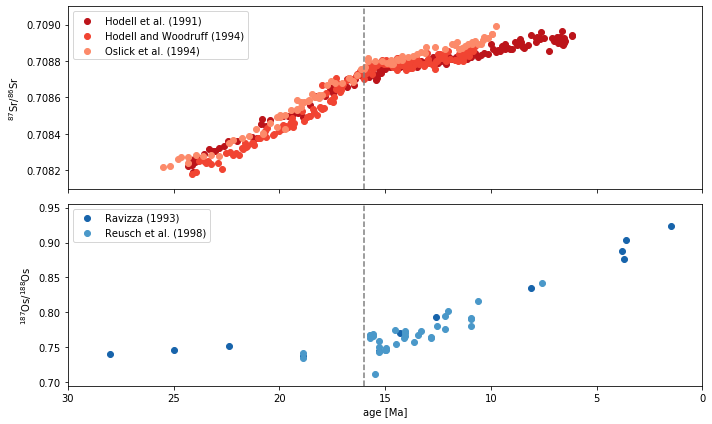

In [4]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

## Functions

Model from Myrow et al. (2015):

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

In [5]:
def calculate_R(X_F_array, X_R_array, X_R_initial, X_n_t, X_t_step, X_tau):
    """
    Perform the seawater model calculations for element X.
    
    Parameters
    ----------
    X_F_array : array with shape (X_n_t, i)
        Fluxes (mol/yr) - each row represents a time slice, and each column represents a source.
        
    X_R_array : array with shape (X_n_t, i)
        Isotope composition - each row represents a time slice, and each column represents a source.
        
    X_R_initial : float
        Initial isotope composition.
        
    X_n_t : int
        Number of model time steps.
        
    X_t_step : float
        Number of years between model time steps.
        
    X_tau : float
        Residence time of element X (yrs).
        
    Returns
    -------
    X_R_SW : array with shape (X_n_t,)
        Isotope composition of seawater.
    """
    X_R_SW = np.zeros(X_n_t)
    X_R_SW[0] = X_R_initial
    
    for i in range(1, X_n_t):
        X_F_total = np.sum(X_F_array[i,:])
        X_R_sum = np.sum((X_F_array[i,:]/X_F_total) * (X_R_array[i,:] - X_R_SW[i-1]))
        d_X_R = (X_R_sum / X_tau) * X_t_step
        X_R_SW[i] = X_R_SW[i-1] + d_X_R
        
    return X_R_SW

Rb decay - equations from Vidal (1994), referenced in Goddéris et al. (2017):

In [6]:
def get_MOR_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for MOR.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_MOR = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb * t))
    
    return r_MOR
    
def get_cc_87Sr86Sr(t):
    """
    Get the 87Sr/86Sr for continental crust.
    """
    BABI = 0.69897
    lamb = 1.42e-11
    RbSr_mantle = 0.025
    
    r_cc = BABI + (0.2783*RbSr_mantle*(9.3485+BABI))*(1-np.exp(-lamb*2e9)) +\
                  (0.2783*RbSr_mantle*(9.3485+BABI))*10*(1-np.exp(-lamb*(t-2e9)))
    
    return r_cc

def convert_to_tbp(tsf):
    """
    Convert time since formation (tsf) to time before present (tbp).
    """
    tbp = 4.54e9 - tsf
    return tbp

def convert_to_tsf(tbp):
    """
    Convert tbp to tsf.
    """
    tsf = 4.54e9 - tbp
    return tsf

at 50 Ma, cc  = 0.7252
at 50 Ma, LIP = 0.7033
###
at 0 Ma, cc  = 0.7257
at 0 Ma, LIP = 0.7033


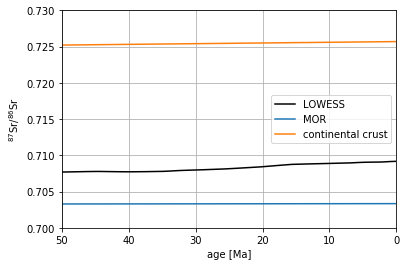

In [7]:
time_evolution = np.linspace(0,4.54e9,500)
MOR_evolution = get_MOR_87Sr86Sr(time_evolution)
cc_evolution = get_cc_87Sr86Sr(time_evolution)

# print some numbers
print('at 50 Ma, cc  = {:.4f}'.format(get_cc_87Sr86Sr(convert_to_tsf(50e6))))
print('at 50 Ma, LIP = {:.4f}'.format(get_MOR_87Sr86Sr(convert_to_tsf(50e6))))
print('###')
print('at 0 Ma, cc  = {:.4f}'.format(get_cc_87Sr86Sr(convert_to_tsf(0))))
print('at 0 Ma, LIP = {:.4f}'.format(get_MOR_87Sr86Sr(convert_to_tsf(0))))

# convert time to Ma
time_evolution = (time_evolution[::-1])/1e6

fig, ax = plt.subplots()
ax.plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')
ax.plot(time_evolution, MOR_evolution, label='MOR', c='C0')
ax.plot(time_evolution, cc_evolution, label='continental crust', c='C1')
ax.set_xlabel('age [Ma]')
ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.set_xlim(50,0)
ax.set_ylim(0.700,0.7300)
ax.grid()
ax.legend()

plt.show(fig)

## Reproduce Myrow et al. (2015)

First, reproduce results from Myrow et al. (2015).

Osmium notes:

* Residence time for osmium is from Oxburgh (2001), which estimated a value of 8-10 kyrs.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [8]:
# model time : yrs
Os_t_step = 0.01e6
Os_t = np.arange(28e6, 11e6-Os_t_step, -Os_t_step)
Os_n_t = len(Os_t)

# residence time : yrs
Os_tau = 9000

# F : mol/yr
# R : 187Os/188Os

###################
# invariant sources
Os_F_HT_hydrothermal = np.ones(Os_n_t) * 10.5
Os_R_HT_hydrothermal = np.ones(Os_n_t) * 0.26

Os_F_LT_hydrothermal = np.ones(Os_n_t) * 105.1
Os_R_LT_hydrothermal = np.ones(Os_n_t) * 0.11

Os_F_cosmic = np.ones(Os_n_t) * 52.6
Os_R_cosmic = np.ones(Os_n_t) * 0.127

Os_F_eolian = np.ones(Os_n_t) * 36.8
Os_R_eolian = np.ones(Os_n_t) * 1.05

Os_F_rivers = np.ones(Os_n_t) * 1577
Os_R_rivers = np.ones(Os_n_t) * 0.7934
###################

###################
# Himalayan source
Os_amu = 190.23

# F : 28-16 Ma
Os_F_Himalayas_A = np.zeros(len(Os_t[Os_t>16e6]))

# F : 16-11 Ma
Os_F_Himalayas_B_rate = (1.95e-6 * 1000 / Os_amu) * Os_t_step
Os_F_Himalayas_B = np.linspace(0,
                               Os_F_Himalayas_B_rate*(len(Os_t[Os_t<=16e6])-1),
                               len(Os_t[Os_t<=16e6]))

Os_F_Himalayas = np.concatenate([Os_F_Himalayas_A, Os_F_Himalayas_B])

# R : 28-11 Ma
Os_R_Himalayas = np.ones(Os_n_t) * 3.0
###################

# merge into array
Os_sources = ['HT hydrothermal',
              'LT hydrothermal',
              'cosmic',
              'eolian',
              'rivers',
              'Himalayas']
OS_n_sources = len(Os_sources)
Os_F_array = np.stack([Os_F_HT_hydrothermal,
                       Os_F_LT_hydrothermal,
                       Os_F_cosmic,
                       Os_F_eolian,
                       Os_F_rivers,
                       Os_F_Himalayas], axis=1)
Os_R_array = np.stack([Os_R_HT_hydrothermal,
                       Os_R_LT_hydrothermal,
                       Os_R_cosmic,
                       Os_R_eolian,
                       Os_R_rivers,
                       Os_R_Himalayas], axis=1)

# calculate 187Os/188Os evolution
Os_R_SW = calculate_R(Os_F_array, Os_R_array, 0.7356, Os_n_t, Os_t_step, Os_tau)

Strontium notes:

* Residence time for strontium is from Myrow et al. (2015), which estimated a 2-4 million years.
* Values for invariant sources are taken straight from Myrow et al. (2015)
* Values for the Himalayas are taken straight from Myrow et al. (2015)

In [9]:
# model time : yrs
Sr_t_step = 0.01e6
Sr_t = np.arange(23e6, 10e6-Sr_t_step, -Sr_t_step)
Sr_n_t = len(Sr_t)

# residence time : yrs
Sr_tau = 3e6

# F : mol/yr
# R : 87Sr/86Sr

###################
# invariant sources
Sr_F_diagenetic = np.ones(Sr_n_t) * 3.4e9
Sr_R_diagenetic = np.ones(Sr_n_t) * 0.708

Sr_F_hydrothermal = np.ones(Sr_n_t) * 8.4e9
Sr_R_hydrothermal = np.ones(Sr_n_t) * 0.7025

Sr_F_rivers = np.ones(Sr_n_t) * 31e9
Sr_R_rivers = np.ones(Sr_n_t) * 0.7103
###################

###################
# varying source
Sr_amu = 87.62

# F : 23-16 Ma
Sr_F_Himalayas_A_rate = 1.3e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_A = np.linspace(0.01e9,
                               0.01e9+Sr_F_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# F : 16-10 Ma
Sr_F_Himalayas_B_rate = 1.1e-7 * 1e9 * Sr_t_step
Sr_F_Himalayas_B = np.linspace(Sr_F_Himalayas_A[-1],
                               Sr_F_Himalayas_A[-1]+Sr_F_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_F_Himalayas = np.concatenate([Sr_F_Himalayas_A, Sr_F_Himalayas_B])

# R: 23-16 Ma
Sr_R_Himalayas_A_rate = 1.2e-9 * Sr_t_step
Sr_R_Himalayas_A = np.linspace(0.715,
                               0.715+Sr_R_Himalayas_A_rate*(len(Sr_t[Sr_t>16e6])-1),
                               len(Sr_t[Sr_t>16e6]))

# R: 16-10 Ma
Sr_R_Himalayas_B_rate = -0.8e-9 * Sr_t_step
Sr_R_Himalayas_B = np.linspace(Sr_R_Himalayas_A[-1],
                               Sr_R_Himalayas_A[-1]+Sr_R_Himalayas_B_rate*(len(Sr_t[Sr_t<=16e6])-1),
                               len(Sr_t[Sr_t<=16e6]))

Sr_R_Himalayas = np.concatenate([Sr_R_Himalayas_A, Sr_R_Himalayas_B])
###################

# merge into array
Sr_sources = ['diagenetic',
              'hydrothermal',
              'rivers',
              'Himalayas']
Sr_n_sources = len(Sr_sources)
Sr_F_array = np.stack([Sr_F_diagenetic,
                       Sr_F_hydrothermal,
                       Sr_F_rivers,
                       Sr_F_Himalayas], axis=1)
Sr_R_array = np.stack([Sr_R_diagenetic,
                       Sr_R_hydrothermal,
                       Sr_R_rivers,
                       Sr_R_Himalayas], axis=1)

# calculate 87Sr/86Sr evolution
Sr_R_SW = calculate_R(Sr_F_array, Sr_R_array, 0.7082, Sr_n_t, Sr_t_step, Sr_tau)

Plot:

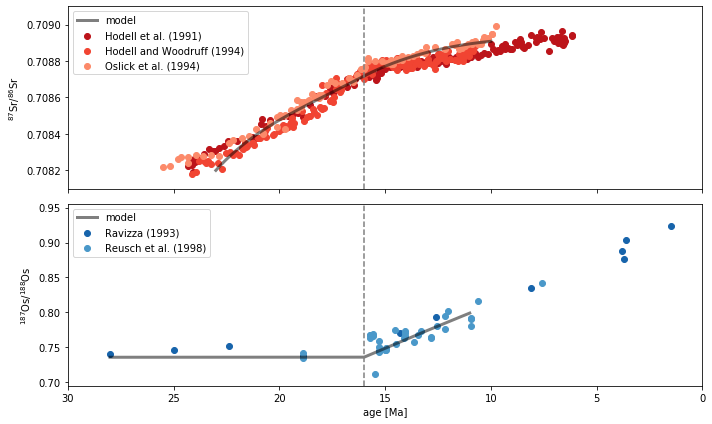

In [10]:
# plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,6), sharex=True)

# Sr
Sr_cmap = get_cmap('Reds')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.8)], label='Hodell et al. (1991)')

ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.6)], label='Hodell and Woodruff (1994)')

ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(Sr_t/1e6, Sr_R_SW, c='k', lw=3, alpha=0.5, label='model')

# Os
Os_cmap = get_cmap('Blues')

ax[1].scatter(Ravizza1993_age, Ravizza1993_Os,
              c=[Os_cmap(0.8)], label='Ravizza (1993)')

ax[1].scatter(Reusch1998_age, Reusch1998_Os,
              c=[Os_cmap(0.6)], label='Reusch et al. (1998)')

ax[1].plot(Os_t/1e6, Os_R_SW, c='k', lw=3, alpha=0.5, label='model')

# prettify
ax[0].axvline(16, ls='--', c='C7')
ax[1].axvline(16, ls='--', c='C7')

ax[0].set_ylim(0.7081, 0.7091)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend()

ax[1].set_ylabel('$^{187}$Os/$^{188}$Os')
ax[1].set_xlabel('age [Ma]')
ax[1].set_xlim(30,0)
ax[1].legend()

fig.tight_layout()
plt.show(fig)

## Scenario 1

$$
\frac{dR_{SW}}{dt} = \frac{1}{\tau} \sum_{i} \frac{F_{i}}{F_{tot}}(R_{i} - R_{SW})
$$

The values that we will use:
    
| Material           | $^{87}$Sr/$^{86}$Sr | [Mg] (ppm) | [Ca] (ppm) | [Sr] (ppm) |
| :----------------: | :-----------------: | :--------: | :--------: | :--------: |
| continental crust  | n/a                 | 12800      | 23750      | 310        |
| juvenile           | 0.7035              | 45500      | 71600      | 465        |
| carbonate          | 0.7080              | 47000      | 302300     | 610        |
| hydrothermal       | 0.7030              | n/a        | n/a        | n/a        |

* marine $^{87}$Sr/$^{86}$Sr
    * McArthur et al. (2012)
        * ~0.7077 at 40 Ma
    * Krabbenhöft et al. (2010)
        * 56 ± 13 e9 mol/yr
        
* globally averaged Sr fluxes
    * Allègre et al. (2010)
        * radiogenic lithologies = ∼15%
        * juvenile lithologies = ∼40%, 0.7035
        * carbonate = ∼35%, 0.7080
        * hydrothermal = ∼10%, 0.7030
        
* seawater Sr residence time
    * Krabbenhöft et al. (2010)
        * ~1.7-3.7 m.y.
    * Ravizza and Zachos (2003)
        * 2.4 m.y.
        
* rock compositions
    * Turekian and Wedepohl (1961)
        * carbonate values in table above
    * Wedepohl (1995)
        * radiogenic values in table above
    * taking the mean of Turekian and Wedepohl (1961) and Taylor (1964)
        * juvenile values in table above
        
* Himalayan Sr
    * Derry and France-Lanord (1996)
        * Bengal fan pedogenic clay Sr isotopic composition - proxy for paleo-river water
    * Quade et al. (1997)
        * soil carbonate Sr isotopic composition - proxy for paleo-river water
    * Oliver et al. (2003)
        * ~70% of Sr is from carbonates, ~30% of Sr is from silicates
    * Krabbenhöft et al. (2010)
        * Sr flux from Brahmaputra is 3.25 e8 mol/yr
        * Sr flux from Ganges is 3.25 e8 mol/yr
        * Sr flux from Indus is 3.00 e8 mol/yr

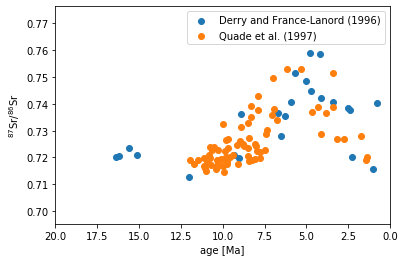

In [11]:
# Derry and France-Lanord (1996) data
Derry1996 = pd.read_csv('Data/Derry1996a.csv')

# remove samples with low d18O
Derry1996 = Derry1996[(pd.isnull(Derry1996['d18O']))|(Derry1996['d18O']>17)]

# remove 2um samples from Hole 718C
Derry1996 = Derry1996[~((Derry1996['hole']=='718C')&(Derry1996['type']==2))]

# remove 50um samples
Derry1996 = Derry1996[Derry1996['type']!=50]

# remove samples with low e_Nd
Derry1996 = Derry1996[(pd.isnull(Derry1996['e_Nd']))|(Derry1996['e_Nd']>-20)]

# if a sample has multiple size fractions, remove the smaller ones
Derry1996_unique = Derry1996['depth'].unique()
drop_inds = []
for i in range(len(Derry1996_unique)):
    Derry1996_slice = Derry1996[Derry1996['depth']==Derry1996_unique[i]]
    if len(Derry1996_slice)>1:
        drop_ind = Derry1996_slice[Derry1996_slice['type']==np.max(Derry1996_slice['type'])].index[0]
        drop_inds.append(drop_ind)
Derry1996.drop(drop_inds, inplace=True)

# Quade et al. (1997) data
Quade1997 = pd.read_csv('Data/Quade1997a_3a.csv')

# plot
fig, ax = plt.subplots()

ax.scatter(Derry1996['age'], Derry1996['87Sr/86Sr'], c='C0', label='Derry and France-Lanord (1996)')
ax.scatter(Quade1997['age'], Quade1997['87Sr/86Sr'], c='C1', label='Quade et al. (1997)')

ax.set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax.set_xlabel('age [Ma]')
ax.set_xlim(20,0)
ax.legend()

plt.show(fig)

Chemical compositions:

In [12]:
# ppm to mol/kg
conc_MgCa_rad = (12800 / 1e6 / 24.305) + (23750 / 1e6 / 40.078)
conc_Sr_rad = 310 / 1e6 / 87.62
conc_MgCa_juv = (45500 / 1e6 / 24.305) + (71600 / 1e6 / 40.078)
conc_Sr_juv = 465 / 1e6 / 87.62
conc_MgCa_crb = (47000 / 1e6 / 24.305) + (302300 / 1e6 / 40.078)
conc_Sr_crb = 610 / 1e6 / 87.62

Set up the time vector:

In [13]:
# stage start ages : yrs
stage_A = 60e6
stage_B = 35e6
stage_C = 16e6

# model time : yrs
t_step = 0.01e6
t = np.arange(stage_A, 0-t_step, -t_step)
n_t = len(t)
n_t_A = len(t[t>stage_B])
n_t_B = len(t[(t<=stage_B)&(t>stage_C)])
n_t_C = len(t[t<=stage_C])
n_t_Ca = len(t[(t<=stage_C)&(t>10e6)])
n_t_Cb = len(t[t<=10e6])

# residence time : yrs
Sr_tau = 2.4e6

Invariant characteristics:

In [14]:
# R : 87Sr/86Sr
R_Sr_rad = get_cc_87Sr86Sr(convert_to_tsf(t))
R_Sr_juv = np.linspace(0.7035, 0.7035, n_t)
R_Sr_crb = np.linspace(0.7080, 0.7080, n_t)
R_Sr_hyd = np.linspace(0.7030, 0.7030, n_t)

Initial values:

In [15]:
# total Sr flux : mol/yr
F_Sr_A_i = 56e9

# Himalayan Sr flux
F_Sr_Him_A_i = 1e8

# lithology Sr flux : mol/yr
F_Sr_rad_A_i = 0.125 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_juv_A_i = 0.425 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_crb_A_i = 0.350 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_hyd_A_i = 0.100 * (F_Sr_A_i-F_Sr_Him_A_i)

# initial Himalayan composition
R_Sr_Him_A_i = 0.720

# check to make sure it all sums to 1
if (F_Sr_rad_A_i + F_Sr_juv_A_i + F_Sr_crb_A_i + F_Sr_hyd_A_i + F_Sr_Him_A_i) != F_Sr_A_i:
    F_sum_check = False
else:
    F_sum_check = True
print('flux sum check = {}'.format(F_sum_check))

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_A_i = F_Sr_Him_A_i * 0.3
F_Sr_Him_crb_A_i = F_Sr_Him_A_i * 0.7
F_Sr_all_rad_A_i = F_Sr_rad_A_i + F_Sr_Him_rad_A_i

# print ratios
print('')
print('rad = {:.2f} vs 0.15'.format(F_Sr_all_rad_A_i/F_Sr_A_i))
print('juv = {:.2f} vs 0.40'.format(F_Sr_juv_A_i/F_Sr_A_i))
print('crb = {:.2f} vs 0.35'.format((F_Sr_crb_A_i+F_Sr_Him_crb_A_i)/F_Sr_A_i))
print('hyd = {:.2f} vs 0.10'.format(F_Sr_hyd_A_i/F_Sr_A_i))

# total weathering flux : kg/yr
F_W_all_rad_A_i = F_Sr_all_rad_A_i / conc_Sr_rad
F_W_juv_A_i = F_Sr_juv_A_i / conc_Sr_juv

# silicate Mg and Ca flux : mol/yr
F_MgCa_all_rad_A_i = F_W_all_rad_A_i * conc_MgCa_rad
F_MgCa_juv_A_i = F_W_juv_A_i * conc_MgCa_juv

# total silicate Mg and Ca flux
F_MgCa_sil = F_MgCa_all_rad_A_i + F_MgCa_juv_A_i

flux sum check = True

rad = 0.13 vs 0.15
juv = 0.42 vs 0.40
crb = 0.35 vs 0.35
hyd = 0.10 vs 0.10


Stage A (spin up to steady-state):

In [16]:
F_Sr_rad_A = np.linspace(F_Sr_rad_A_i, F_Sr_rad_A_i, n_t_A)
F_Sr_juv_A = np.linspace(F_Sr_juv_A_i, F_Sr_juv_A_i, n_t_A)
F_Sr_crb_A = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_A)
F_Sr_hyd_A = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_A)
F_Sr_Him_A = np.linspace(F_Sr_Him_A_i, F_Sr_Him_A_i, n_t_A)
R_Sr_Him_A = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_A)

Stage B:

In [17]:
# change Himalayan flux linearly
F_Sr_Him_C_f = 1e9
F_Sr_Him_B_C_step = (F_Sr_Him_C_f - F_Sr_Him_A_i) / (n_t_B + n_t_C - 1)
F_Sr_Him_B_i = F_Sr_Him_A_i
F_Sr_Him_B_f = F_Sr_Him_B_i + F_Sr_Him_B_C_step*(n_t_B-1)

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_B_f = F_Sr_Him_B_f * 0.3
F_Sr_Him_crb_B_f = F_Sr_Him_B_f * 0.7

# increase radiogenic flux
F_Sr_rad_B_i = F_Sr_rad_A_i
F_Sr_rad_B_f = F_Sr_rad_B_i * 1.42
F_W_rad_B_f = F_Sr_rad_B_f / conc_Sr_rad
F_MgCa_rad_B_f = F_W_rad_B_f * conc_MgCa_rad

# calculate total radiogenic flux
F_Sr_all_rad_B_f = F_Sr_rad_B_f + F_Sr_Him_rad_B_f
F_W_all_rad_B_f = F_Sr_all_rad_B_f / conc_Sr_rad
F_MgCa_all_rad_B_f = F_W_all_rad_B_f * conc_MgCa_rad

# adjust juvenile flux to maintain constant silicate Mg and Ca flux
F_MgCa_juv_B_f = F_MgCa_sil - F_MgCa_all_rad_B_f
F_W_juv_B_f = F_MgCa_juv_B_f / conc_MgCa_juv
F_Sr_juv_B_i = F_Sr_juv_A_i
F_Sr_juv_B_f = F_W_juv_B_f * conc_Sr_juv

# fill in vectors
F_Sr_rad_B = np.linspace(F_Sr_rad_B_i, F_Sr_rad_B_f, n_t_B)
F_Sr_juv_B = np.linspace(F_Sr_juv_B_i, F_Sr_juv_B_f, n_t_B)
F_Sr_crb_B = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_B)
F_Sr_hyd_B = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_B)
F_Sr_Him_B = np.linspace(F_Sr_Him_B_i, F_Sr_Him_B_f, n_t_B)
R_Sr_Him_B = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_B)

Stage C:

In [18]:
# continue to increase the Himalayan flux linearly
F_Sr_Him_C_i = F_Sr_Him_B_f + F_Sr_Him_B_C_step

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_C_i = F_Sr_Him_C_i * 0.3
F_Sr_Him_crb_C_i = F_Sr_Him_C_i * 0.7
F_Sr_Him_rad_C_f = F_Sr_Him_C_f * 0.3
F_Sr_Him_crb_C_f = F_Sr_Him_C_f * 0.7

# calculate Himalayas radiogenic Mg and Ca flux
F_W_Him_rad_C_i = F_Sr_Him_rad_C_i / conc_Sr_rad
F_MgCa_Him_rad_C_i = F_W_Him_rad_C_i * conc_MgCa_rad
F_W_Him_rad_C_f = F_Sr_Him_rad_C_f / conc_Sr_rad
F_MgCa_Him_rad_C_f = F_W_Him_rad_C_f * conc_MgCa_rad

# change total radiogenic flux according to GEOCLIM results
F_MgCa_all_rad_C_i = F_MgCa_Him_rad_C_i + F_MgCa_rad_B_f
F_MgCa_all_rad_C_f = F_MgCa_all_rad_C_i * 0.96

# make the change be accommodated entirely within non-Himalayan radiogenics
F_MgCa_rad_C_f = F_MgCa_all_rad_C_f - F_MgCa_Him_rad_C_f

# calculate radiogenic fluxes
F_W_rad_C_f = F_MgCa_rad_C_f / conc_MgCa_rad
F_Sr_rad_C_i = F_Sr_rad_B_f
F_Sr_rad_C_f = F_W_rad_C_f * conc_Sr_rad

# adjust juvenile flux to maintain constant silicate Mg and Ca flux
F_MgCa_juv_C_f = F_MgCa_sil - F_MgCa_all_rad_C_f
F_W_juv_C_f = F_MgCa_juv_C_f / conc_MgCa_juv
F_Sr_juv_C_i = F_Sr_juv_B_f
F_Sr_juv_C_f = F_W_juv_C_f * conc_Sr_juv

# change the Himalayan Sr isotope composition according to Bengal Fan data
R_Sr_Him_Cb_f = 0.750
R_Sr_Him_Ca = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_Ca)
R_Sr_Him_Cb = np.linspace(R_Sr_Him_A_i, R_Sr_Him_Cb_f, n_t_Cb)
R_Sr_Him_C = np.concatenate([R_Sr_Him_Ca, R_Sr_Him_Cb])

# fill in forcing vectors
F_Sr_rad_C = np.linspace(F_Sr_rad_C_i, F_Sr_rad_C_f, n_t_C)
F_Sr_juv_C = np.linspace(F_Sr_juv_C_i, F_Sr_juv_C_f, n_t_C)
F_Sr_crb_C = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_C)
F_Sr_hyd_C = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_C)
F_Sr_Him_C = np.linspace(F_Sr_Him_C_i, F_Sr_Him_C_f, n_t_C)

Compute:

In [19]:
F_Sr_rad = np.concatenate([F_Sr_rad_A, F_Sr_rad_B, F_Sr_rad_C])
F_Sr_juv = np.concatenate([F_Sr_juv_A, F_Sr_juv_B, F_Sr_juv_C])
F_Sr_crb = np.concatenate([F_Sr_crb_A, F_Sr_crb_B, F_Sr_crb_C])
F_Sr_hyd = np.concatenate([F_Sr_hyd_A, F_Sr_hyd_B, F_Sr_hyd_C])
F_Sr_Him = np.concatenate([F_Sr_Him_A, F_Sr_Him_B, F_Sr_Him_C])
R_Sr_Him = np.concatenate([R_Sr_Him_A, R_Sr_Him_B, R_Sr_Him_C])

F_Sr_tot = F_Sr_rad + F_Sr_juv + F_Sr_crb + F_Sr_hyd + F_Sr_Him

F_Sr_Him_rad = F_Sr_Him * 0.3
F_Sr_Him_crb = F_Sr_Him * 0.7

# merge into array
Sr_sources = ['radiogenic',
              'juvenile',
              'carbonate',
              'hydrothermal',
              'Himalayas']
Sr_n_sources = len(Sr_sources)
F_Sr_array = np.stack([F_Sr_rad,
                       F_Sr_juv,
                       F_Sr_crb,
                       F_Sr_hyd,
                       F_Sr_Him], axis=1)
R_Sr_array = np.stack([R_Sr_rad,
                       R_Sr_juv,
                       R_Sr_crb,
                       R_Sr_hyd,
                       R_Sr_Him], axis=1)

# calculate 87Sr/86Sr evolution
R_Sr_SW = calculate_R(F_Sr_array, R_Sr_array, 0.7077, n_t, t_step, Sr_tau)

Plot:

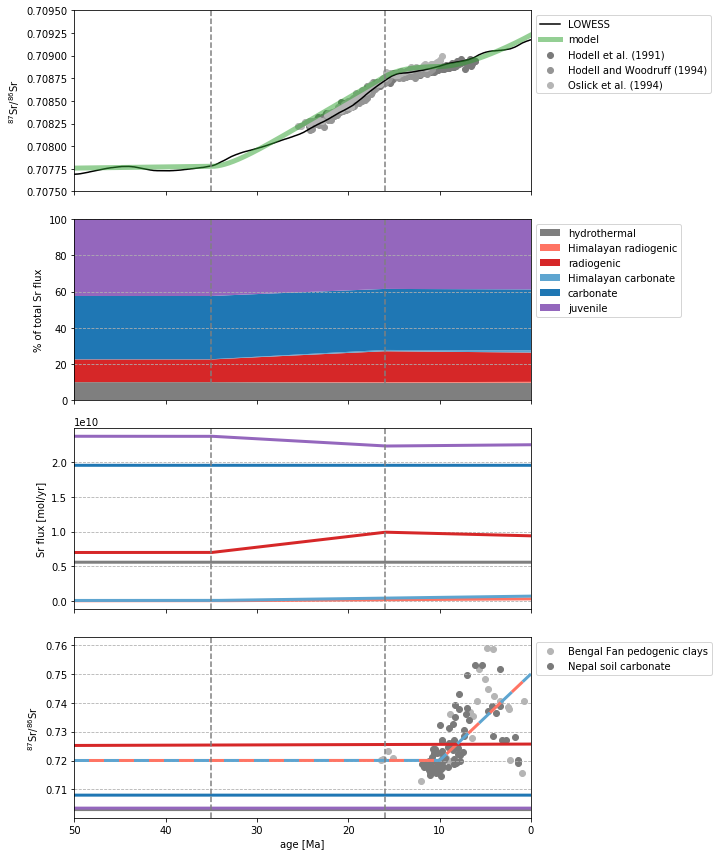

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,12), sharex=True)

# Sr isotopes
Sr_cmap = get_cmap('Greys')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.6)], label='Hodell et al. (1991)')
ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.5)], label='Hodell and Woodruff (1994)')
ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax[0].plot(t/1e6, R_Sr_SW, c='#2ca02c', lw=5, alpha=0.5, label='model')

ax[0].set_xlim(50,0)
ax[0].set_ylim(0.7075,0.7095)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

# Sr flux fractions
ax[1].stackplot(t/1e6,
                F_Sr_hyd/F_Sr_tot*100,
                F_Sr_Him_rad/F_Sr_tot*100,
                F_Sr_rad/F_Sr_tot*100,
                F_Sr_Him_crb/F_Sr_tot*100,
                F_Sr_crb/F_Sr_tot*100,
                F_Sr_juv/F_Sr_tot*100,
                labels=['hydrothermal',
                        'Himalayan radiogenic',
                        'radiogenic',
                        'Himalayan carbonate',
                        'carbonate',
                        'juvenile'],
                colors=['#7f7f7f','#ff7464','#d62728','#5ea5d0','#1f77b4','#9467bd'])

ax[1].set_ylim(0,100)
ax[1].set_ylabel('% of total Sr flux')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1].yaxis.grid(ls='--')

# Sr flux
ax[2].plot(t/1e6, F_Sr_hyd,
           label='hydrothermal', c='#7f7f7f', lw=3)
ax[2].plot(t/1e6, F_Sr_Him_rad,
           label='Himalayan radiogenic', c='#ff7464', lw=3)
ax[2].plot(t/1e6, F_Sr_rad,
           label='radiogenic', c='#d62728', lw=3)
ax[2].plot(t/1e6, F_Sr_Him_crb,
           label='Himalayan carbonate', c='#5ea5d0', lw=3)
ax[2].plot(t/1e6, F_Sr_crb,
           label='carbonate', c='#1f77b4', lw=3)
ax[2].plot(t/1e6, F_Sr_juv,
           label='juvenile', c='#9467bd', lw=3)

ax[2].set_ylabel('Sr flux [mol/yr]')
ax[2].yaxis.grid(ls='--')

# Sr isotopes
ax[3].plot(t/1e6, R_Sr_hyd,
           label='__nolabel__', c='#7f7f7f', lw=3)
ax[3].plot(t/1e6, R_Sr_Him,
           label='__nolabel__', c='#ff7464', lw=3, linestyle=(0,(5,5)))
ax[3].plot(t/1e6, R_Sr_rad,
           label='__nolabel__', c='#d62728', lw=3)
ax[3].plot(t/1e6, R_Sr_Him,
           label='__nolabel__', c='#5ea5d0', lw=3, linestyle=(5,(5,5)))
ax[3].plot(t/1e6, R_Sr_crb,
           label='__nolabel__', c='#1f77b4', lw=3)
ax[3].plot(t/1e6, R_Sr_juv,
           label='__nolabel__', c='#9467bd', lw=3)
ax[3].scatter(Derry1996['age'], Derry1996['87Sr/86Sr'],
              c=[Sr_cmap(0.4)], label='Bengal Fan pedogenic clays')
ax[3].scatter(Quade1997['age'], Quade1997['87Sr/86Sr'],
              c=[Sr_cmap(0.6)], label='Nepal soil carbonate')

ax[3].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[3].set_xlabel('age [Ma]')
ax[3].yaxis.grid(ls='--')
ax[3].legend(loc='upper left', bbox_to_anchor=(1,1))

# the axvlines
for i in range(4):
    ax[i].axvline(stage_B/1e6, ls='--', c='C7')
    ax[i].axvline(stage_C/1e6, ls='--', c='C7')

fig.tight_layout()
plt.show(fig)

Store results:

In [21]:
s1_t = t
s1_R_Sr_SW = R_Sr_SW
s1_F_Sr_hyd = F_Sr_hyd
s1_F_Sr_Him_rad = F_Sr_Him_rad
s1_F_Sr_rad = F_Sr_rad
s1_F_Sr_Him_crb = F_Sr_Him_crb
s1_F_Sr_crb = F_Sr_crb
s1_F_Sr_juv = F_Sr_juv
s1_F_Sr_tot = F_Sr_tot
s1_R_Sr_hyd = R_Sr_hyd
s1_R_Sr_Him = R_Sr_Him
s1_R_Sr_rad = R_Sr_rad
s1_R_Sr_crb = R_Sr_crb
s1_R_Sr_juv = R_Sr_juv

## Scenario 2

Chemical compositions:

In [22]:
# ppm to mol/kg
conc_MgCa_rad = (12800 / 1e6 / 24.305) + (23750 / 1e6 / 40.078)
conc_Sr_rad = 310 / 1e6 / 87.62
conc_MgCa_juv = (45500 / 1e6 / 24.305) + (71600 / 1e6 / 40.078)
conc_Sr_juv = 465 / 1e6 / 87.62
conc_MgCa_crb = (47000 / 1e6 / 24.305) + (302300 / 1e6 / 40.078)
conc_Sr_crb = 610 / 1e6 / 87.62

Set up the time vector:

In [23]:
# stage start ages : yrs
stage_A = 60e6
stage_B = 35e6
stage_C = 16e6

# model time : yrs
t_step = 0.01e6
t = np.arange(stage_A, 0-t_step, -t_step)
n_t = len(t)
n_t_A = len(t[t>stage_B])
n_t_B = len(t[(t<=stage_B)&(t>stage_C)])
n_t_C = len(t[t<=stage_C])
n_t_Ca = len(t[(t<=stage_C)&(t>10e6)])
n_t_Cb = len(t[t<=10e6])

# residence time : yrs
Sr_tau = 2.4e6

Invariant characteristics:

In [24]:
# R : 87Sr/86Sr
R_Sr_rad = get_cc_87Sr86Sr(convert_to_tsf(t))
R_Sr_juv = np.linspace(0.7035, 0.7035, n_t)
R_Sr_crb = np.linspace(0.7080, 0.7080, n_t)
R_Sr_hyd = np.linspace(0.7030, 0.7030, n_t)

Initial values:

In [25]:
# total Sr flux : mol/yr
F_Sr_A_i = 56e9

# Himalayan Sr flux
F_Sr_Him_A_i = 1e8

# lithology Sr flux : mol/yr
F_Sr_rad_A_i = 0.125 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_juv_A_i = 0.425 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_crb_A_i = 0.350 * (F_Sr_A_i-F_Sr_Him_A_i)
F_Sr_hyd_A_i = 0.100 * (F_Sr_A_i-F_Sr_Him_A_i)

# initial Himalayan composition
R_Sr_Him_A_i = 0.720

# check to make sure it all sums to 1
if (F_Sr_rad_A_i + F_Sr_juv_A_i + F_Sr_crb_A_i + F_Sr_hyd_A_i + F_Sr_Him_A_i) != F_Sr_A_i:
    F_sum_check = False
else:
    F_sum_check = True
print('flux sum check = {}'.format(F_sum_check))

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_A_i = F_Sr_Him_A_i * 0.3
F_Sr_Him_crb_A_i = F_Sr_Him_A_i * 0.7
F_Sr_all_rad_A_i = F_Sr_rad_A_i + F_Sr_Him_rad_A_i

# print ratios
print('')
print('rad = {:.2f} vs 0.15'.format(F_Sr_all_rad_A_i/F_Sr_A_i))
print('juv = {:.2f} vs 0.40'.format(F_Sr_juv_A_i/F_Sr_A_i))
print('crb = {:.2f} vs 0.35'.format((F_Sr_crb_A_i+F_Sr_Him_crb_A_i)/F_Sr_A_i))
print('hyd = {:.2f} vs 0.10'.format(F_Sr_hyd_A_i/F_Sr_A_i))

# total weathering flux : kg/yr
F_W_all_rad_A_i = F_Sr_all_rad_A_i / conc_Sr_rad
F_W_juv_A_i = F_Sr_juv_A_i / conc_Sr_juv

# silicate Mg and Ca flux : mol/yr
F_MgCa_all_rad_A_i = F_W_all_rad_A_i * conc_MgCa_rad
F_MgCa_juv_A_i = F_W_juv_A_i * conc_MgCa_juv

# total silicate Mg and Ca flux
F_MgCa_sil = F_MgCa_all_rad_A_i + F_MgCa_juv_A_i

flux sum check = True

rad = 0.13 vs 0.15
juv = 0.42 vs 0.40
crb = 0.35 vs 0.35
hyd = 0.10 vs 0.10


Stage A (spin up to steady-state):

In [26]:
F_Sr_rad_A = np.linspace(F_Sr_rad_A_i, F_Sr_rad_A_i, n_t_A)
F_Sr_juv_A = np.linspace(F_Sr_juv_A_i, F_Sr_juv_A_i, n_t_A)
F_Sr_crb_A = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_A)
F_Sr_hyd_A = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_A)
F_Sr_Him_A = np.linspace(F_Sr_Him_A_i, F_Sr_Him_A_i, n_t_A)
R_Sr_Him_A = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_A)

Stage B:

In [27]:
# change Himalayan flux linearly
F_Sr_Him_C_f = 1e9
F_Sr_Him_B_C_step = (F_Sr_Him_C_f - F_Sr_Him_A_i) / (n_t_B + n_t_C - 1)
F_Sr_Him_B_i = F_Sr_Him_A_i
F_Sr_Him_B_f = F_Sr_Him_B_i + F_Sr_Him_B_C_step*(n_t_B-1)

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_B_f = F_Sr_Him_B_f * 0.3
F_Sr_Him_crb_B_f = F_Sr_Him_B_f * 0.7

# increase radiogenic flux
F_Sr_rad_B_i = F_Sr_rad_A_i
F_Sr_rad_B_f = F_Sr_rad_B_i * 1.42
F_W_rad_B_f = F_Sr_rad_B_f / conc_Sr_rad
F_MgCa_rad_B_f = F_W_rad_B_f * conc_MgCa_rad

# calculate total radiogenic flux
F_Sr_all_rad_B_f = F_Sr_rad_B_f + F_Sr_Him_rad_B_f
F_W_all_rad_B_f = F_Sr_all_rad_B_f / conc_Sr_rad
F_MgCa_all_rad_B_f = F_W_all_rad_B_f * conc_MgCa_rad

# adjust juvenile flux to maintain constant silicate Mg and Ca flux
F_MgCa_juv_B_f = F_MgCa_sil - F_MgCa_all_rad_B_f
F_W_juv_B_f = F_MgCa_juv_B_f / conc_MgCa_juv
F_Sr_juv_B_i = F_Sr_juv_A_i
F_Sr_juv_B_f = F_W_juv_B_f * conc_Sr_juv

# fill in vectors
F_Sr_rad_B = np.linspace(F_Sr_rad_B_i, F_Sr_rad_B_f, n_t_B)
F_Sr_juv_B = np.linspace(F_Sr_juv_B_i, F_Sr_juv_B_f, n_t_B)
F_Sr_crb_B = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_B)
F_Sr_hyd_B = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_B)
F_Sr_Him_B = np.linspace(F_Sr_Him_B_i, F_Sr_Him_B_f, n_t_B)
R_Sr_Him_B = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_B)

Stage C:

In [28]:
# continue to increase the Himalayan flux linearly
F_Sr_Him_C_i = F_Sr_Him_B_f + F_Sr_Him_B_C_step

# split Himalayas into 30% radiogenic and 70% carbonate
F_Sr_Him_rad_C_i = F_Sr_Him_C_i * 0.3
F_Sr_Him_crb_C_i = F_Sr_Him_C_i * 0.7
F_Sr_Him_rad_C_f = F_Sr_Him_C_f * 0.3
F_Sr_Him_crb_C_f = F_Sr_Him_C_f * 0.7

# calculate Himalayas radiogenic Mg and Ca flux
F_W_Him_rad_C_i = F_Sr_Him_rad_C_i / conc_Sr_rad
F_MgCa_Him_rad_C_i = F_W_Him_rad_C_i * conc_MgCa_rad
F_W_Him_rad_C_f = F_Sr_Him_rad_C_f / conc_Sr_rad
F_MgCa_Him_rad_C_f = F_W_Him_rad_C_f * conc_MgCa_rad

# change total radiogenic flux according to GEOCLIM results
F_MgCa_all_rad_C_i = F_MgCa_Him_rad_C_i + F_MgCa_rad_B_f
F_MgCa_all_rad_C_f = F_MgCa_all_rad_C_i * 0.96

# make the change be accommodated entirely within non-Himalayan radiogenics
F_MgCa_rad_C_f = F_MgCa_all_rad_C_f - F_MgCa_Him_rad_C_f

# calculate radiogenic fluxes
F_W_rad_C_f = F_MgCa_rad_C_f / conc_MgCa_rad
F_Sr_rad_C_i = F_Sr_rad_B_f
F_Sr_rad_C_f = F_W_rad_C_f * conc_Sr_rad

# adjust juvenile flux to maintain constant silicate Mg and Ca flux
F_MgCa_juv_C_f = F_MgCa_sil - F_MgCa_all_rad_C_f
F_W_juv_C_f = F_MgCa_juv_C_f / conc_MgCa_juv
F_Sr_juv_C_i = F_Sr_juv_B_f
F_Sr_juv_C_f = F_W_juv_C_f * conc_Sr_juv

# change the Himalayan Sr isotope composition according to Bengal Fan data
R_Sr_Him_Cb_f = 0.720
R_Sr_Him_Ca = np.linspace(R_Sr_Him_A_i, R_Sr_Him_A_i, n_t_Ca)
R_Sr_Him_Cb = np.linspace(R_Sr_Him_A_i, R_Sr_Him_Cb_f, n_t_Cb)
R_Sr_Him_C = np.concatenate([R_Sr_Him_Ca, R_Sr_Him_Cb])

# fill in forcing vectors
F_Sr_rad_C = np.linspace(F_Sr_rad_C_i, F_Sr_rad_C_f, n_t_C)
F_Sr_juv_C = np.linspace(F_Sr_juv_C_i, F_Sr_juv_C_f, n_t_C)
F_Sr_crb_C = np.linspace(F_Sr_crb_A_i, F_Sr_crb_A_i, n_t_C)
F_Sr_hyd_C = np.linspace(F_Sr_hyd_A_i, F_Sr_hyd_A_i, n_t_C)
F_Sr_Him_C = np.linspace(F_Sr_Him_C_i, F_Sr_Him_C_f, n_t_C)

Compute:

In [29]:
F_Sr_rad = np.concatenate([F_Sr_rad_A, F_Sr_rad_B, F_Sr_rad_C])
F_Sr_juv = np.concatenate([F_Sr_juv_A, F_Sr_juv_B, F_Sr_juv_C])
F_Sr_crb = np.concatenate([F_Sr_crb_A, F_Sr_crb_B, F_Sr_crb_C])
F_Sr_hyd = np.concatenate([F_Sr_hyd_A, F_Sr_hyd_B, F_Sr_hyd_C])
F_Sr_Him = np.concatenate([F_Sr_Him_A, F_Sr_Him_B, F_Sr_Him_C])
R_Sr_Him = np.concatenate([R_Sr_Him_A, R_Sr_Him_B, R_Sr_Him_C])

F_Sr_tot = F_Sr_rad + F_Sr_juv + F_Sr_crb + F_Sr_hyd + F_Sr_Him

F_Sr_Him_rad = F_Sr_Him * 0.3
F_Sr_Him_crb = F_Sr_Him * 0.7

# merge into array
Sr_sources = ['radiogenic',
              'juvenile',
              'carbonate',
              'hydrothermal',
              'Himalayas']
Sr_n_sources = len(Sr_sources)
F_Sr_array = np.stack([F_Sr_rad,
                       F_Sr_juv,
                       F_Sr_crb,
                       F_Sr_hyd,
                       F_Sr_Him], axis=1)
R_Sr_array = np.stack([R_Sr_rad,
                       R_Sr_juv,
                       R_Sr_crb,
                       R_Sr_hyd,
                       R_Sr_Him], axis=1)

# calculate 87Sr/86Sr evolution
R_Sr_SW = calculate_R(F_Sr_array, R_Sr_array, 0.7077, n_t, t_step, Sr_tau)

Plot:

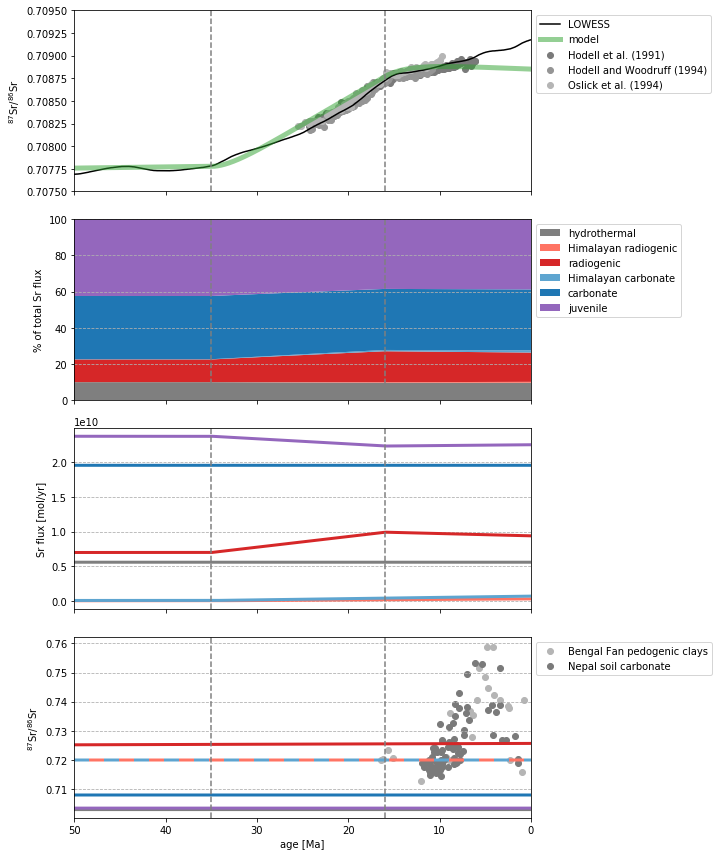

In [30]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,12), sharex=True)

# Sr isotopes
Sr_cmap = get_cmap('Greys')

ax[0].scatter(Hodell1991_age, Hodell1991_Sr,
              c=[Sr_cmap(0.6)], label='Hodell et al. (1991)')
ax[0].scatter(Hodell1994_age, Hodell1994_Sr,
              c=[Sr_cmap(0.5)], label='Hodell and Woodruff (1994)')
ax[0].scatter(Oslick1994_age, Oslick1994_Sr,
              c=[Sr_cmap(0.4)], label='Oslick et al. (1994)')

ax[0].plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax[0].plot(t/1e6, R_Sr_SW, c='#2ca02c', lw=5, alpha=0.5, label='model')

ax[0].set_xlim(50,0)
ax[0].set_ylim(0.7075,0.7095)
ax[0].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[0].legend(loc='upper left', bbox_to_anchor=(1,1))

# Sr flux fractions
ax[1].stackplot(t/1e6,
                F_Sr_hyd/F_Sr_tot*100,
                F_Sr_Him_rad/F_Sr_tot*100,
                F_Sr_rad/F_Sr_tot*100,
                F_Sr_Him_crb/F_Sr_tot*100,
                F_Sr_crb/F_Sr_tot*100,
                F_Sr_juv/F_Sr_tot*100,
                labels=['hydrothermal',
                        'Himalayan radiogenic',
                        'radiogenic',
                        'Himalayan carbonate',
                        'carbonate',
                        'juvenile'],
                colors=['#7f7f7f','#ff7464','#d62728','#5ea5d0','#1f77b4','#9467bd'])

ax[1].set_ylim(0,100)
ax[1].set_ylabel('% of total Sr flux')
ax[1].legend(loc='upper left', bbox_to_anchor=(1,1))
ax[1].yaxis.grid(ls='--')

# Sr flux
ax[2].plot(t/1e6, F_Sr_hyd,
           label='hydrothermal', c='#7f7f7f', lw=3)
ax[2].plot(t/1e6, F_Sr_Him_rad,
           label='Himalayan radiogenic', c='#ff7464', lw=3)
ax[2].plot(t/1e6, F_Sr_rad,
           label='radiogenic', c='#d62728', lw=3)
ax[2].plot(t/1e6, F_Sr_Him_crb,
           label='Himalayan carbonate', c='#5ea5d0', lw=3)
ax[2].plot(t/1e6, F_Sr_crb,
           label='carbonate', c='#1f77b4', lw=3)
ax[2].plot(t/1e6, F_Sr_juv,
           label='juvenile', c='#9467bd', lw=3)

ax[2].set_ylabel('Sr flux [mol/yr]')
ax[2].yaxis.grid(ls='--')

# Sr isotopes
ax[3].plot(t/1e6, R_Sr_hyd,
           label='__nolabel__', c='#7f7f7f', lw=3)
ax[3].plot(t/1e6, R_Sr_Him,
           label='__nolabel__', c='#ff7464', lw=3, linestyle=(0,(5,5)))
ax[3].plot(t/1e6, R_Sr_rad,
           label='__nolabel__', c='#d62728', lw=3)
ax[3].plot(t/1e6, R_Sr_Him,
           label='__nolabel__', c='#5ea5d0', lw=3, linestyle=(5,(5,5)))
ax[3].plot(t/1e6, R_Sr_crb,
           label='__nolabel__', c='#1f77b4', lw=3)
ax[3].plot(t/1e6, R_Sr_juv,
           label='__nolabel__', c='#9467bd', lw=3)
ax[3].scatter(Derry1996['age'], Derry1996['87Sr/86Sr'],
              c=[Sr_cmap(0.4)], label='Bengal Fan pedogenic clays')
ax[3].scatter(Quade1997['age'], Quade1997['87Sr/86Sr'],
              c=[Sr_cmap(0.6)], label='Nepal soil carbonate')

ax[3].set_ylabel('$^{87}$Sr/$^{86}$Sr')
ax[3].set_xlabel('age [Ma]')
ax[3].yaxis.grid(ls='--')
ax[3].legend(loc='upper left', bbox_to_anchor=(1,1))

# the axvlines
for i in range(4):
    ax[i].axvline(stage_B/1e6, ls='--', c='C7')
    ax[i].axvline(stage_C/1e6, ls='--', c='C7')

fig.tight_layout()
plt.show(fig)

Store results:

In [31]:
s2_t = t
s2_R_Sr_SW = R_Sr_SW
s2_F_Sr_hyd = F_Sr_hyd
s2_F_Sr_Him_rad = F_Sr_Him_rad
s2_F_Sr_rad = F_Sr_rad
s2_F_Sr_Him_crb = F_Sr_Him_crb
s2_F_Sr_crb = F_Sr_crb
s2_F_Sr_juv = F_Sr_juv
s2_F_Sr_tot = F_Sr_tot
s2_R_Sr_hyd = R_Sr_hyd
s2_R_Sr_Him = R_Sr_Him
s2_R_Sr_rad = R_Sr_rad
s2_R_Sr_crb = R_Sr_crb
s2_R_Sr_juv = R_Sr_juv

## Together

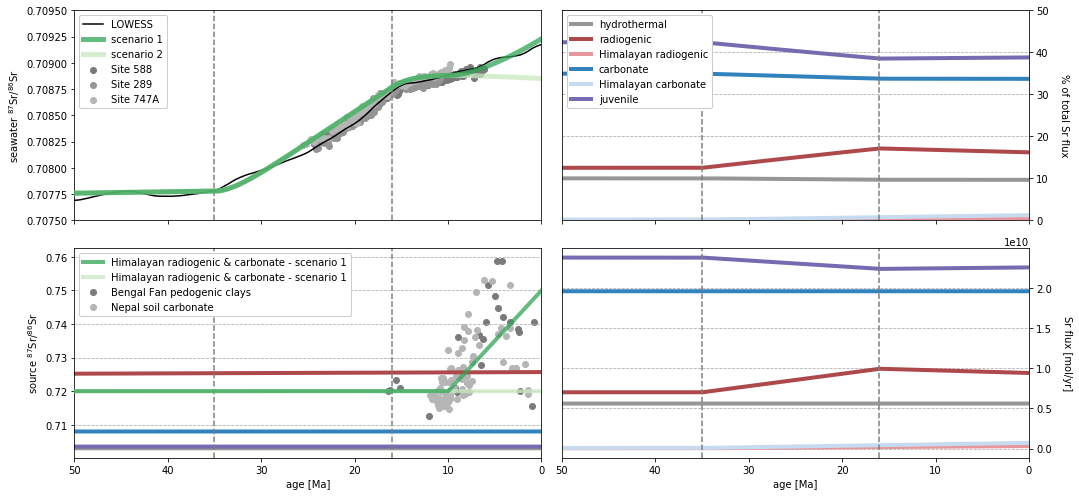

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,7), sharex=True)

data_cmap = get_cmap('Greys')
source_cmap_b = get_cmap('tab20b')
source_cmap_c = get_cmap('tab20c')

data_colors = {'Site 588':data_cmap(0.6),
               'Site 289':data_cmap(0.5),
               'Site 747A':data_cmap(0.4),
               'Bengal Fan':data_cmap(0.6),
               'Nepal':data_cmap(0.4)}

source_colors = {'hydrothermal':source_cmap_c(0.875),
                 'Himalayan radiogenic':source_cmap_b(0.775),
                 'radiogenic':source_cmap_b(0.675),
                 'Himalayan carbonate':source_cmap_c(0.175),
                 'carbonate':source_cmap_c(0.025),
                 'juvenile':source_cmap_c(0.625),
                 'scenario 1':source_cmap_c(0.425),
                 'scenario 2':source_cmap_c(0.575)}

# Sr isotopes
ax[0][0].scatter(Hodell1991_age, Hodell1991_Sr,
                 c=[data_colors['Site 588']], label='Site 588')
ax[0][0].scatter(Hodell1994_age, Hodell1994_Sr,
                 c=[data_colors['Site 289']], label='Site 289')
ax[0][0].scatter(Oslick1994_age, Oslick1994_Sr,
                 c=[data_colors['Site 747A']], label='Site 747A')

ax[0][0].plot(LOWESS_age, LOWESS_Sr_mean, c='k', label='LOWESS')

ax[0][0].plot(s1_t/1e6, s1_R_Sr_SW,
              c=source_colors['scenario 1'], lw=5, alpha=0.75, zorder=99, label='scenario 1')
ax[0][0].plot(s2_t/1e6, s2_R_Sr_SW,
              c=source_colors['scenario 2'], lw=5, alpha=0.75, zorder=98, label='scenario 2')

ax[0][0].set_xlim(50,0)
ax[0][0].set_ylim(0.7075,0.7095)
ax[0][0].set_ylabel('seawater $^{87}$Sr/$^{86}$Sr')
ax[0][0].legend(loc='upper left', framealpha=1)

# Sr flux fractions
ax[0][1].plot(s1_t/1e6, s1_F_Sr_hyd/s1_F_Sr_tot*100,
              label='hydrothermal', c=source_colors['hydrothermal'], lw=4)
ax[0][1].plot(s1_t/1e6, s1_F_Sr_rad/s1_F_Sr_tot*100,
              label='radiogenic', c=source_colors['radiogenic'], lw=4)
ax[0][1].plot(s1_t/1e6, s1_F_Sr_Him_rad/s1_F_Sr_tot*100,
              label='Himalayan radiogenic', c=source_colors['Himalayan radiogenic'], lw=4)
ax[0][1].plot(s1_t/1e6, s1_F_Sr_crb/s1_F_Sr_tot*100,
              label='carbonate', c=source_colors['carbonate'], lw=4)
ax[0][1].plot(s1_t/1e6, s1_F_Sr_Him_crb/s1_F_Sr_tot*100,
              label='Himalayan carbonate', c=source_colors['Himalayan carbonate'], lw=4)
ax[0][1].plot(s1_t/1e6, s1_F_Sr_juv/s1_F_Sr_tot*100,
              label='juvenile', c=source_colors['juvenile'], lw=4)

ax[0][1].set_ylim(0,50)
ax[0][1].set_ylabel('% of total Sr flux', rotation=270, labelpad=20)
ax[0][1].yaxis.grid(ls='--')
ax[0][1].yaxis.tick_right()
ax[0][1].yaxis.set_label_position('right')
ax[0][1].legend(loc='upper left', framealpha=1)

# Sr flux
ax[1][1].plot(s1_t/1e6, s1_F_Sr_hyd,
              label='hydrothermal', c=source_colors['hydrothermal'], lw=4)
ax[1][1].plot(s1_t/1e6, s1_F_Sr_rad,
              label='radiogenic', c=source_colors['radiogenic'], lw=4)
ax[1][1].plot(s1_t/1e6, s1_F_Sr_Him_rad,
              label='Himalayan radiogenic', c=source_colors['Himalayan radiogenic'], lw=4)
ax[1][1].plot(s1_t/1e6, s1_F_Sr_crb,
              label='carbonate', c=source_colors['carbonate'], lw=4)
ax[1][1].plot(s1_t/1e6, s1_F_Sr_Him_crb,
              label='Himalayan carbonate', c=source_colors['Himalayan carbonate'], lw=4)
ax[1][1].plot(s1_t/1e6, s1_F_Sr_juv,
              label='juvenile', c=source_colors['juvenile'], lw=4)

ax[1][1].set_ylabel('Sr flux [mol/yr]', rotation=270, labelpad=20)
ax[1][1].yaxis.tick_right()
ax[1][1].yaxis.set_label_position('right')
ax[1][1].yaxis.grid(ls='--')
ax[1][1].set_xlabel('age [Ma]')

# Sr isotopes
ax[1][0].plot(s1_t/1e6, s1_R_Sr_hyd,
              label='__nolegend__', c=source_colors['hydrothermal'], lw=4)
ax[1][0].plot(s1_t/1e6, s1_R_Sr_rad,
              label='__nolegend__', c=source_colors['radiogenic'], lw=4)
ax[1][0].plot(s1_t/1e6, s1_R_Sr_crb,
              label='__nolegend__', c=source_colors['carbonate'], lw=4)
ax[1][0].plot(s1_t/1e6, s1_R_Sr_juv,
              label='__nolegend__', c=source_colors['juvenile'], lw=4)
ax[1][0].plot(s1_t/1e6, s1_R_Sr_Him,
              label='Himalayan radiogenic & carbonate - scenario 1',
              c=source_colors['scenario 1'], zorder=99, lw=4, alpha=0.75)
ax[1][0].plot(s2_t/1e6, s2_R_Sr_Him,
              label='Himalayan radiogenic & carbonate - scenario 1',
              c=source_colors['scenario 2'], zorder=98, lw=4, alpha=0.75)

ax[1][0].scatter(Derry1996['age'], Derry1996['87Sr/86Sr'],
                 c=[data_colors['Bengal Fan']], label='Bengal Fan pedogenic clays')
ax[1][0].scatter(Quade1997['age'], Quade1997['87Sr/86Sr'],
                 c=[data_colors['Nepal']], label='Nepal soil carbonate')

ax[1][0].set_ylabel('source $^{87}$Sr/$^{86}$Sr')
ax[1][0].set_xlabel('age [Ma]')
ax[1][0].yaxis.grid(ls='--')
ax[1][0].legend(loc='upper left', framealpha=1)

# the axvlines
for i in range(2):
    for j in range(2):
        ax[i][j].axvline(stage_B/1e6, ls='--', c='C7')
        ax[i][j].axvline(stage_C/1e6, ls='--', c='C7')

fig.tight_layout()
#plt.savefig('../../../Manuscript/Figures/seawater_model.pdf', bbox_inches='tight')
plt.show(fig)